In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder, StandardScaler

In [2]:
PATH = './Data/Raw/'

In [3]:
files = os.listdir(PATH)

pbp_df = pd.DataFrame()
for file in files:
    temp_df = pd.read_csv(PATH + file, on_bad_lines = 'skip')
    temp_df['File'] = file[4:8] # to be able to filter data later on by file 
    pbp_df = pbp_df.append(temp_df)

C:\Users\Lucas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (15,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
print(F'Data of {pbp_df["GameId"].nunique()} individual Games.')

print(F'''
Shape: {pbp_df.shape}
      
Columns:
{pbp_df.columns.tolist()}''')

print(F"""
Missing:
{pbp_df.isnull().mean().mul(100).sort_values(ascending = False).round(2).astype(str) + '%'}    
""")

Data of 2494 individual Games.

Shape: (445983, 46)
      
Columns:
['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Unnamed: 10', 'SeriesFirstDown', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin', 'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'Formation', 'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown', 'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed', 'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble', 'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful', 'RushDirection', 'YardLineFixed', 'YardLineDirection', 'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType', 'PenaltyYards', 'File']

Missing:
Unnamed: 10                       100.0%
Unnamed: 12                       100.0%
Challenger                        100.0%
Unnamed: 17                       100.0%
Unnamed: 16                       100.0%
PenaltyTeam                       91.86%
PenaltyType  

In [5]:
# drop unnecessary columns
pbp_df = pbp_df.drop(labels = ['Unnamed: 12', 'Unnamed: 10', 'Unnamed: 16', 'Unnamed: 17', 'Challenger'], axis = 1)

In [6]:
# show how many points of data are available for every team per year
pbp_df.groupby(['OffenseTeam', 'File']).size().mean() 

1287.20625

In [7]:
pbp_df['PlayType'].unique()

array([nan, 'EXCEPTION', 'TIMEOUT', 'KICK OFF', 'QB KNEEL', 'PASS',
       'SACK', 'RUSH', 'CLOCK STOP', 'PUNT', 'EXTRA POINT', 'NO PLAY',
       'FIELD GOAL', 'SCRAMBLE', 'FUMBLES', 'TWO-POINT CONVERSION',
       'PENALTY', '0'], dtype=object)

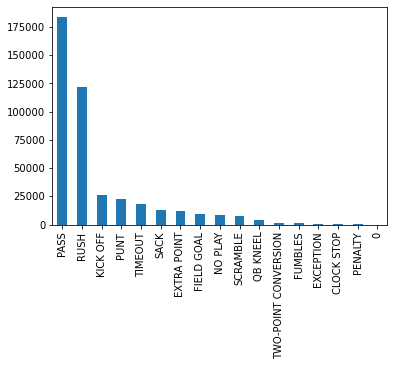

In [8]:
pbp_df['PlayType'].value_counts().plot(kind = 'bar')

In [9]:
# reduce down to relevant play types
pbp_df_simple = pbp_df.loc[pbp_df['PlayType'].isin(['PASS','RUSH'])]

In [10]:
pbp_df['Formation'].unique()

array([nan, 'UNDER CENTER', 'NO HUDDLE', 'SHOTGUN', 'PUNT',
       'NO HUDDLE SHOTGUN', 'FIELD GOAL', 'WILDCAT', 'DEEP LEFT'],
      dtype=object)

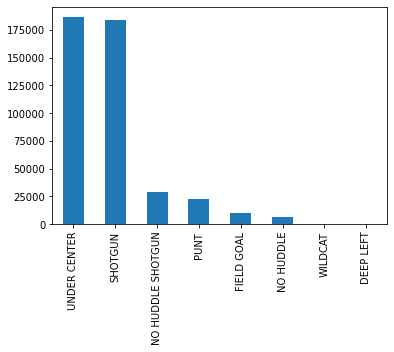

In [11]:
pbp_df['Formation'].value_counts().plot(kind = 'bar')

In [12]:
pbp_df = pbp_df.loc[pbp_df['Formation'].isin(['UNDER CENTER', 'NO HUDDLE', 'SHOTGUN', 'NO HUDDLE SHOTGUN'])]